<a href="https://colab.research.google.com/github/shuvad23/image-classification-projects/blob/main/Flower_Classification_(5_Class).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Project Name: Flower Classification (5-Class):




- Description:
  > This project performs flower image classification using transfer learning with a pretrained ResNet-50 model in PyTorch.
  
  > The Oxford Flowers-102 dataset is automatically downloaded and a custom subset of 5 flower classes is created dynamically without manual data collection.
  
  > The model is fine-tuned using frozen layers initially and later unfrozen for improved accuracy.

- Skills Used:

      1. PyTorch

      2. Custom Dataset handling

      3. Transfer Learning (ResNet-50)

      4. Fine-tuning

      5. Image Augmentation

      6. Confusion Matrix & Classification Report

🔹 Step 1: Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.metrics import confusion_matrix, classification_report

🔹 Step 2: Custom Dataset Wrapper (IMPORTANT)

In [19]:
class FlowerDataset(Dataset):
    def __init__(self,base_dataset, indices,label_map, transform = None):
        self.base_dataset = base_dataset
        self.indices = indices
        self.label_map = label_map
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, index):
        image, label = self.base_dataset[self.indices[index]]
        label = self.label_map[label]
        if self.transform:
            image = self.transform(image)
        return image,label

🔹 Step 3: Transforms

In [3]:
def get_transforms():
    normalize = transforms.Normalize(
        mean = [0.485, 0.456, 0.406],
        std = [0.229, 0.224, 0.225]
    )

    train_tf = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ])

    val_tf = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])

    return train_tf,val_tf

🔹 Step 4: Model (ResNet-50 Transfer Learning)

In [4]:
class FlowerClassifier(nn.Module):
    def __init__(self, num_classes):
        super(FlowerClassifier, self).__init__()
        self.model = models.resnet50(pretrained = True)

        for param in self.model.parameters():
            param.requires_grad = False

        in_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(in_features,512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512,num_classes)
        )

    def forward(self, x):
        return self.model(x)

    def unfreeze_layers(self):
        for param in self.model.parameters():
            param.requires_grad = True


🔹 Step 5: Training & Validation Functions

In [15]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    loss_sum = 0
    correct = 0

    for batch_idx,(batch_data,batch_labels) in enumerate(loader):
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
        optimizer.zero_grad()
        output = model(batch_data)
        loss = criterion(output, batch_labels)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item() * batch_data.size(0)
        correct += (output.argmax(1) == batch_labels).sum().item()

    return loss_sum / len(loader.dataset), correct / len(loader.dataset)

In [8]:
def validate(model, loader, criterion, device):
    model.eval()
    loss_sum = 0
    correct = 0

    preds , labels = [],[]

    with torch.no_grad():
        for batch_idx,(batch_data,batch_labels) in enumerate(loader):
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
            output = model(batch_data)
            loss = criterion(output, batch_labels)

            loss_sum += loss.item() * batch_data.size(0)
            pred= output.argmax(1)
            correct += (pred == batch_labels).sum().item()

            preds.extend(pred.cpu().numpy())
            labels.extend(batch_labels.cpu().numpy())

    return loss_sum / len(loader.dataset), correct / len(loader.dataset), preds, labels

🔹 Step 6: MAIN (Auto Dataset Download)

In [55]:
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print('Using Device: ',device)

    NUM_CLASSES = 5
    BATCH_SIZE = 32
    EPOCHS = 20
    LR = 1e-4

    train_tf, val_tf = get_transforms()

    # download dataset
    full_train = datasets.Flowers102(root='./data', split='train', download=True, transform=None)
    full_val = datasets.Flowers102(root='./data', split='val', download=True, transform=None)


    # select only 5 classes
    selected_classes = [0, 1, 2, 3, 4]
    train_indices = [i for i, (_, y) in enumerate(full_train) if y in selected_classes]
    val_indices = [i for i, (_, y) in enumerate(full_val) if y in selected_classes]

    label_map = {orig: i for i, orig in enumerate(selected_classes)}
    class_names = [full_train.classes[i] for i in selected_classes]
    print("Selected 5 classes:")
    print(class_names)

    train_ds = FlowerDataset(full_train, train_indices,label_map, train_tf)
    val_ds = FlowerDataset(full_val, val_indices,label_map, val_tf)

    train_loader = DataLoader(train_ds, BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, BATCH_SIZE, shuffle=False)

    model = FlowerClassifier(NUM_CLASSES).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)

    # Training loop
    for epoch in range(EPOCHS):
        if epoch == 5:
            print("Unfreezing model...")
            model.unfreeze_layers()

        tr_loss, tr_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, _, _ = validate(model, val_loader, criterion, device)

        print(f"Epoch {epoch+1}/{EPOCHS}")
        print(f"Train Acc: {tr_acc:.4f} | Val Acc: {val_acc:.4f}")

    torch.save(model.state_dict(), "flower_model.pth")

Using Device:  cuda
Selected 5 classes:
['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold']


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20
Train Acc: 0.2800 | Val Acc: 0.3000
Epoch 2/20
Train Acc: 0.3600 | Val Acc: 0.6200
Epoch 3/20
Train Acc: 0.6200 | Val Acc: 0.6600
Epoch 4/20
Train Acc: 0.6400 | Val Acc: 0.6800
Epoch 5/20
Train Acc: 0.6400 | Val Acc: 0.7200
Unfreezing model...
Epoch 6/20
Train Acc: 0.7800 | Val Acc: 0.8400
Epoch 7/20
Train Acc: 0.9200 | Val Acc: 0.9600
Epoch 8/20
Train Acc: 0.9400 | Val Acc: 0.9800
Epoch 9/20
Train Acc: 0.9800 | Val Acc: 1.0000
Epoch 10/20
Train Acc: 0.9600 | Val Acc: 1.0000
Epoch 11/20
Train Acc: 0.9600 | Val Acc: 1.0000
Epoch 12/20
Train Acc: 1.0000 | Val Acc: 0.9800
Epoch 13/20
Train Acc: 1.0000 | Val Acc: 0.9800
Epoch 14/20
Train Acc: 0.9800 | Val Acc: 0.9600
Epoch 15/20
Train Acc: 0.9800 | Val Acc: 0.9600
Epoch 16/20
Train Acc: 0.9800 | Val Acc: 0.9800
Epoch 17/20
Train Acc: 1.0000 | Val Acc: 0.9600
Epoch 18/20
Train Acc: 1.0000 | Val Acc: 0.9600
Epoch 19/20
Train Acc: 1.0000 | Val Acc: 0.9600
Epoch 20/20
Train Acc: 1.0000 | Val Acc: 0.9600


In [56]:
selected_classes = [0, 1, 2, 3, 4]
class_names = [full_train.classes[i] for i in selected_classes]
print("Selected 5 classes:")
print(class_names)

Selected 5 classes:
['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold']


🔹 Confusion Matrix

In [57]:
def get_predictions(model, dataloader, device):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return y_true, y_pred

🔹 Classification Report

In [58]:
def show_classification_report(y_true, y_pred, class_names):
    print("\n📊 Classification Report\n")
    print(classification_report(
        y_true,
        y_pred,
        target_names=class_names,
        digits=5
    ))

- Confusion Matrix (PROFESSIONAL PLOT)

In [59]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names
    )

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix - Flower Classification")
    plt.tight_layout()
    plt.show()


- Use After Training (FINAL EVALUATION)


📊 Classification Report

                           precision    recall  f1-score   support

            pink primrose    1.00000   1.00000   1.00000        10
hard-leaved pocket orchid    1.00000   1.00000   1.00000        10
         canterbury bells    0.83333   1.00000   0.90909        10
                sweet pea    1.00000   0.80000   0.88889        10
         english marigold    1.00000   1.00000   1.00000        10

                 accuracy                        0.96000        50
                macro avg    0.96667   0.96000   0.95960        50
             weighted avg    0.96667   0.96000   0.95960        50



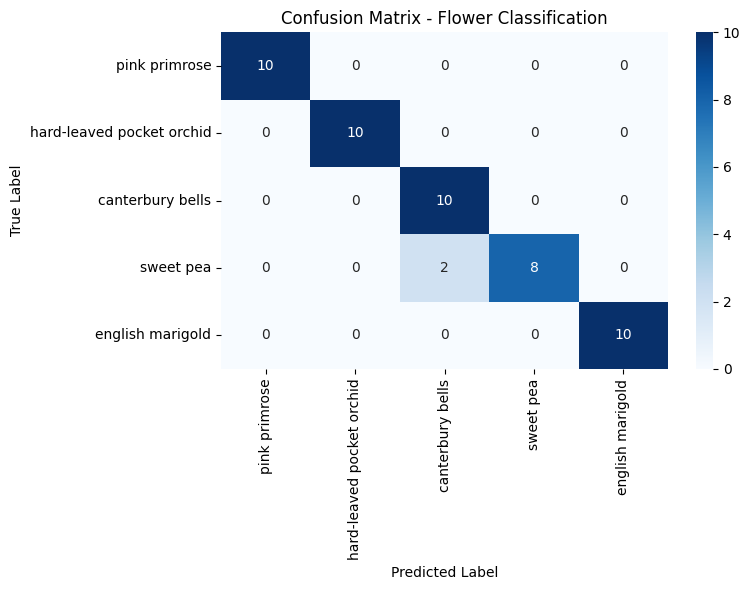

In [60]:
# Get predictions
y_true, y_pred = get_predictions(model, val_loader, device)

# Show report
show_classification_report(y_true, y_pred, class_names)

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, class_names)


✅ STEP 1: Save Model Correctly During Training

In [61]:
MODEL_PATH = "/content/flower_model.pth"

torch.save({
    "model_state": model.state_dict(),
    "class_names": class_names,   # 5 flower names
}, MODEL_PATH)


✅ STEP 2: Inference Code

In [62]:
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

# ===== CONFIG =====
MODEL_PATH = "/content/flower_model.pth"
IMG_SIZE = 224
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===== LOAD MODEL =====
model = FlowerClassifier(num_classes=5)
loaded_data = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(loaded_data["model_state"])
model.to(device)
model.eval()

# Define class names manually (same order as training)
class_names = loaded_data["class_names"]

# ===== INFERENCE FUNCTION =====
def infer_image(image_path):
    image = Image.open(image_path).convert("RGB")

    transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

    tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(tensor)
        probs = torch.softmax(outputs, dim=1)
        conf, idx = torch.max(probs, dim=1)

    label = class_names[idx.item()]
    confidence = conf.item()

    plt.figure(figsize=(4,4))
    plt.imshow(image)
    plt.title(f"{label} ({confidence*100:.2f}%)")
    plt.axis("off")
    plt.show()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ STEP 3: Upload Image in Google Colab

Saving ea5bc38753fb96f6478649c67b491297_e91a131e-0494-49de-8d06-b457ee390b41.jpg to ea5bc38753fb96f6478649c67b491297_e91a131e-0494-49de-8d06-b457ee390b41 (1).jpg


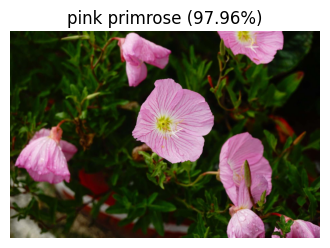

In [71]:
from google.colab import files

uploaded = files.upload()

if uploaded:
    img_path = list(uploaded.keys())[0]
    infer_image(img_path)
else:
    print("No image uploaded")
